Importing python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyriemann.estimation import Covariances
from pyriemann.preprocessing import Whitening
from pyriemann.tangentspace import TangentSpace
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, permutation_test_score
plt.ion()

Defining variables

In [2]:
scoring = 'roc_auc' 
n_folds = 5
p_value_threshold = 0.05
n_permutations = 1000
solver = 'lbfgs'
n_jobs = -1

inputdir = 'datarep/'
subject_number = 1
filename_template = 'subject_%s_data_%s_%s.npz'

Defining the sliding time window (1 sec)

In [3]:
t_min = -0.5  
t_max = 6.5  
time_window_size = 1 
time_step = 1  
epsilon = 0.01 
t_mins = np.arange(t_min, t_max - time_window_size + epsilon, time_step)
t_maxs = np.arange(t_min + time_window_size, t_max + epsilon, time_step)
time_windows = list(zip(t_mins, t_maxs))
n_windows = len(t_mins)
timepoints = np.arange(0,n_windows,1)

Initialize variables

In [4]:
scores = np.zeros(n_windows)
significant = np.zeros(n_windows, dtype=bool)
permutations = np.zeros((n_windows,n_permutations))

Loading the data, estimating the spatial covariance across sensors using a Riemannian metric, removing task-irrelevant covariance across sensors during the trial period based on an estimate of the covariance across sensors measured during the baseline period (whitening), projecting the covariance from the Riemannian manifold to an Euclidean tangent space, training and testing the decoding model, and computing significance using a non-parametric permutation test for each time window.

In [5]:
print(" ")
print("Cross-validated %s using spatial covariance matrix across sensors" % scoring)

for ii, (t_start, t_stop) in enumerate(time_windows):

    print(" ")
    print("time window %s - %s" % (t_start, t_stop))

    bas = np.load(inputdir + 'subject_%s_baseline.npz' % (subject_number), allow_pickle=True)
    B = bas['b']

    data = np.load(inputdir + filename_template % (subject_number, t_start, t_stop), allow_pickle=True)
    X = data['x']

    y = np.load(inputdir + 'subject_%s_ys.npy' % (subject_number), allow_pickle=True)[ii]

    BC = Covariances(estimator='oas').fit_transform(B)
    C = Covariances(estimator='oas').fit_transform(X)

    whi = Whitening(metric='euclid', dim_red=None).fit(BC)
    W = whi.transform(C)

    T = TangentSpace(metric='riemann').fit_transform(W)

    clf = LogisticRegression(solver=solver)
    cv = StratifiedKFold(n_splits=n_folds, random_state=0, shuffle=True)
    print(cv)

    print("Computing %s permutations" % n_permutations)
    score, permutation_scores, p_value = permutation_test_score(clf, T, y, scoring=scoring, cv=cv, n_permutations=n_permutations, n_jobs=n_jobs)

    print("%s : %s" % (scoring, score))
    print("p_value = %s" % p_value)

    scores[ii] = score
    significant[ii] = p_value <= p_value_threshold
    permutations[ii] = permutation_scores

 
Cross-validated roc_auc using spatial covariance matrix across sensors
 
time window -0.5 - 0.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Computing 1000 permutations
roc_auc : 0.5376543209876543
p_value = 0.36563436563436563
 
time window 0.5 - 1.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Computing 1000 permutations
roc_auc : 0.6633670033670034
p_value = 0.026973026973026972
 
time window 1.5 - 2.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Computing 1000 permutations
roc_auc : 0.6074725274725274
p_value = 0.13186813186813187
 
time window 2.5 - 3.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Computing 1000 permutations
roc_auc : 0.7126373626373627
p_value = 0.000999000999000999
 
time window 3.5 - 4.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
Computing 1000 permutations
roc_auc : 0.7234159779614325
p_value = 0.000999000999000999
 
time window 4.5 - 5.5
StratifiedKFold(n_splits=5, random_state=0, shuffle=Tr

Plot results

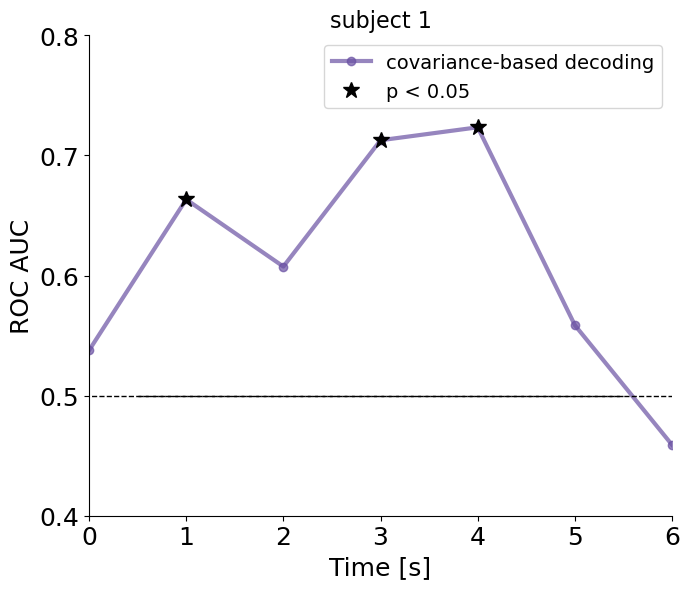

In [6]:
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
ax.plot(timepoints, scores, 'o-', color='#6a51a3', lw=3, label='covariance-based decoding', alpha=0.7)
if np.any(significant): 
    ax.plot(timepoints[significant], scores[significant], ' ', marker='*', color='k', markersize=12, label='p < 0.05')
else:
    ax.plot(0, 0, ' ', marker='*', color='k', markersize=12, label='p < 0.05')
ax.plot(time_windows, np.ones(n_windows) * 0.5, '--', lw=1, color='black')
ax.set_ylabel('ROC AUC', fontsize=18)
ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylim([0.4, 0.8])
ax.set_xlim([0.0, 6.0])
ax.set_yticks([0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_yticklabels([0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.legend(loc=0, fontsize=14)
ax.tick_params(labelsize=18)
ax.set_title('subject %s' % (subject_number), fontsize=16)
plt.tight_layout()

The covariance-based decoding results are significant in three different time-windows.